#  Image Segmentation, Editing and Generation
* This project was written along the course 'Generative AI, from GANs to CLIP, with Python and Pytorch' from Javier Ideami, all credits are due the author;
* The project is based on two pre-trained models;
* Segment Anything (Meta): image segmentation (link below);
* Stable Diffusion: Diffusion-based text-to-image generation model (source: https://huggingface.co/stabilityai/stable-diffusion-2-inpainting);
* Both models and images credit are due the author;



# Libraries

- tqdm = provide progress bar for loops and iterations
- diffusers (Hugging Face) = pre-trained vision/audio generatives models
- transformers (Hugging Face) = pre-trained transformers
- accelerate (Hugging Face) = increase efficiency for training and inference
- Xformers = optimize transformers archicture (transformers are quite pc expensive, especially the self-attetion mechanisms)
- opencv = provide many functions, especially for computer vision

In [ ]:
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers
!pip install -q opencv-python
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q pycocotools matplotlib onnxruntime onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 93.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.8 MB/s eta 0:00:00


In [ ]:
import torch, PIL, cv2, base64, json, requests, copy, sys
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image
from io import BytesIO
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
from numpy import asarray
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Downloading SAM Checkpoint (weights)

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-09-25 12:04:00--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.18.103, 13.35.18.102, 13.35.18.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.18.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   110MB/s    in 22s     

2024-09-25 12:04:22 (112 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



# Setup Diffusion Model

In [ ]:
# EulerScheduler = Denoiser algorithm #
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

# Specify the Euler Archictecture we gonna use #
model_dir="stabilityai/stable-diffusion-2-inpainting"

# Initiate the Euler scheduler with the archicteture in 'model_dir' #
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

# Pipeline Architecture = Required to run model's many operations/inference #
pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir,
                                                   scheduler=scheduler,
                                                   revision="fp16",
                                                   torch_dtype=torch.float16)
# Use in GPU #
device = "cuda"
pipe = pipe.to(device)

# Apply Xformers optimizing to the pipeline #
pipe.enable_xformers_memory_efficient_attention()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c

# Image Setup

In [ ]:
!wget https://images.unsplash.com/photo-1474073705359-5da2a8270c64?q=80&w=1384&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D
!mv photo-1474073705359-5da2a8270c64?q=80 sample_img.jpg

--2024-09-25 12:04:55--  https://images.unsplash.com/photo-1474073705359-5da2a8270c64?q=80
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332863 (1.3M) [image/jpeg]
Saving to: ‘photo-1474073705359-5da2a8270c64?q=80’

photo-1474073705359 100%[===================>]   1.27M  --.-KB/s    in 0.009s  

2024-09-25 12:04:56 (145 MB/s) - ‘photo-1474073705359-5da2a8270c64?q=80’ saved [1332863/1332863]



Source image size: (3923, 5811)
Target image size: (512, 512)


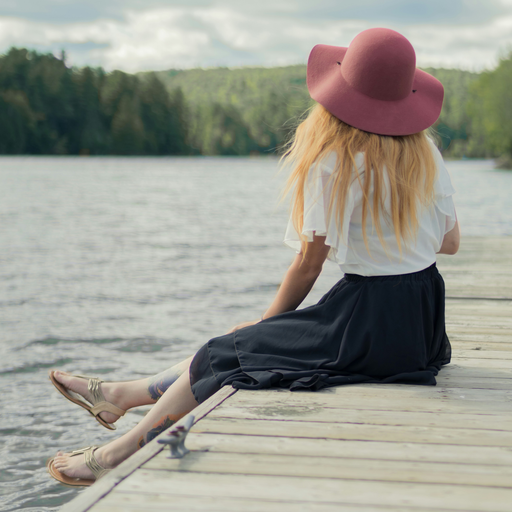

In [ ]:
# Load image #
target_width, target_height = 512,512
source_image = Image.open('sample_img.jpg')

width, height = source_image.size
print(f"Source image size: {source_image.size}")

# Crop image to a square #
source_image = source_image.crop((0, height-width , width , height))  # box=(left, upper, right, lower)

# Resize the image #
source_image = source_image.resize((target_width, target_height), Image.LANCZOS )
print(f"Target image size: {source_image.size}")

# Convert to an array #
segmentation_image = asarray(source_image)

# Display it #
display(source_image)

# SAM initializing

In [ ]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# Initialize model with the checkpoint #
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Initialize mask generator #
mask_generator = SamAutomaticMaskGenerator(
    model=sam, # Model to use
    points_per_side=32,
    pred_iou_thresh=0.99,
    # iou = intersection of union = evaluate how well the segmentation was done
    # evaluate how well the produce mask fit the original element
    # between [0,1] = where 1 is a perfect match
    # the value provided is the threshold = 99% match
    # a lower value will result in more masks, but with lower accuracy
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


# Run SAM

In [ ]:
masks = mask_generator.generate(segmentation_image)

### Print number of masks generated and the keys attached to each of them
print(f"Number of masks generated: {len(masks)}")
print(masks[0].keys())

# Intersection Over Union (IoU) tell us the degree of overlap between two boxes.
# In the case of object detection and segmentation, it refers to the overlap of the Ground Truth and Prediction region

Number of masks generated: 12
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


# Visualize generated masks

# Visualization function

In [ ]:
# Function to visualize the masks generated together with a number that identifies each of them #
def show_anns(anns):
    if len(anns) == 0:
        return

    # Sort masks by area in descending order
    sorted_anns = sorted(enumerate(anns), key=(lambda x: x[1]['area']), reverse=True)
    ax = plt.gca()

    # Disable autoscale to keep the image size consistent
    ax.set_autoscale_on(False)

    # Iterate through each mask and display it on top of the original image
    for original_idx, ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))

        # Generate a random color for the mask
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]

        # Blend the mask with the image, using 0.35 as the alpha value for transparency
        ax.imshow(np.dstack((img, m*0.35)))

        # Find contours of the mask to compute the centroid
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = contours[0]
            M = cv2.moments(cnt)

            # Compute the centroid of the mask if the moment is non-zero
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Display the original index number (1-based) at the centroid of the mask
                # The text is white, bold, and has a font size of 16
                ax.text(cx, cy, str(original_idx), color='white', fontsize=16, ha='center', va='center', fontweight='bold')

## Run Visualization

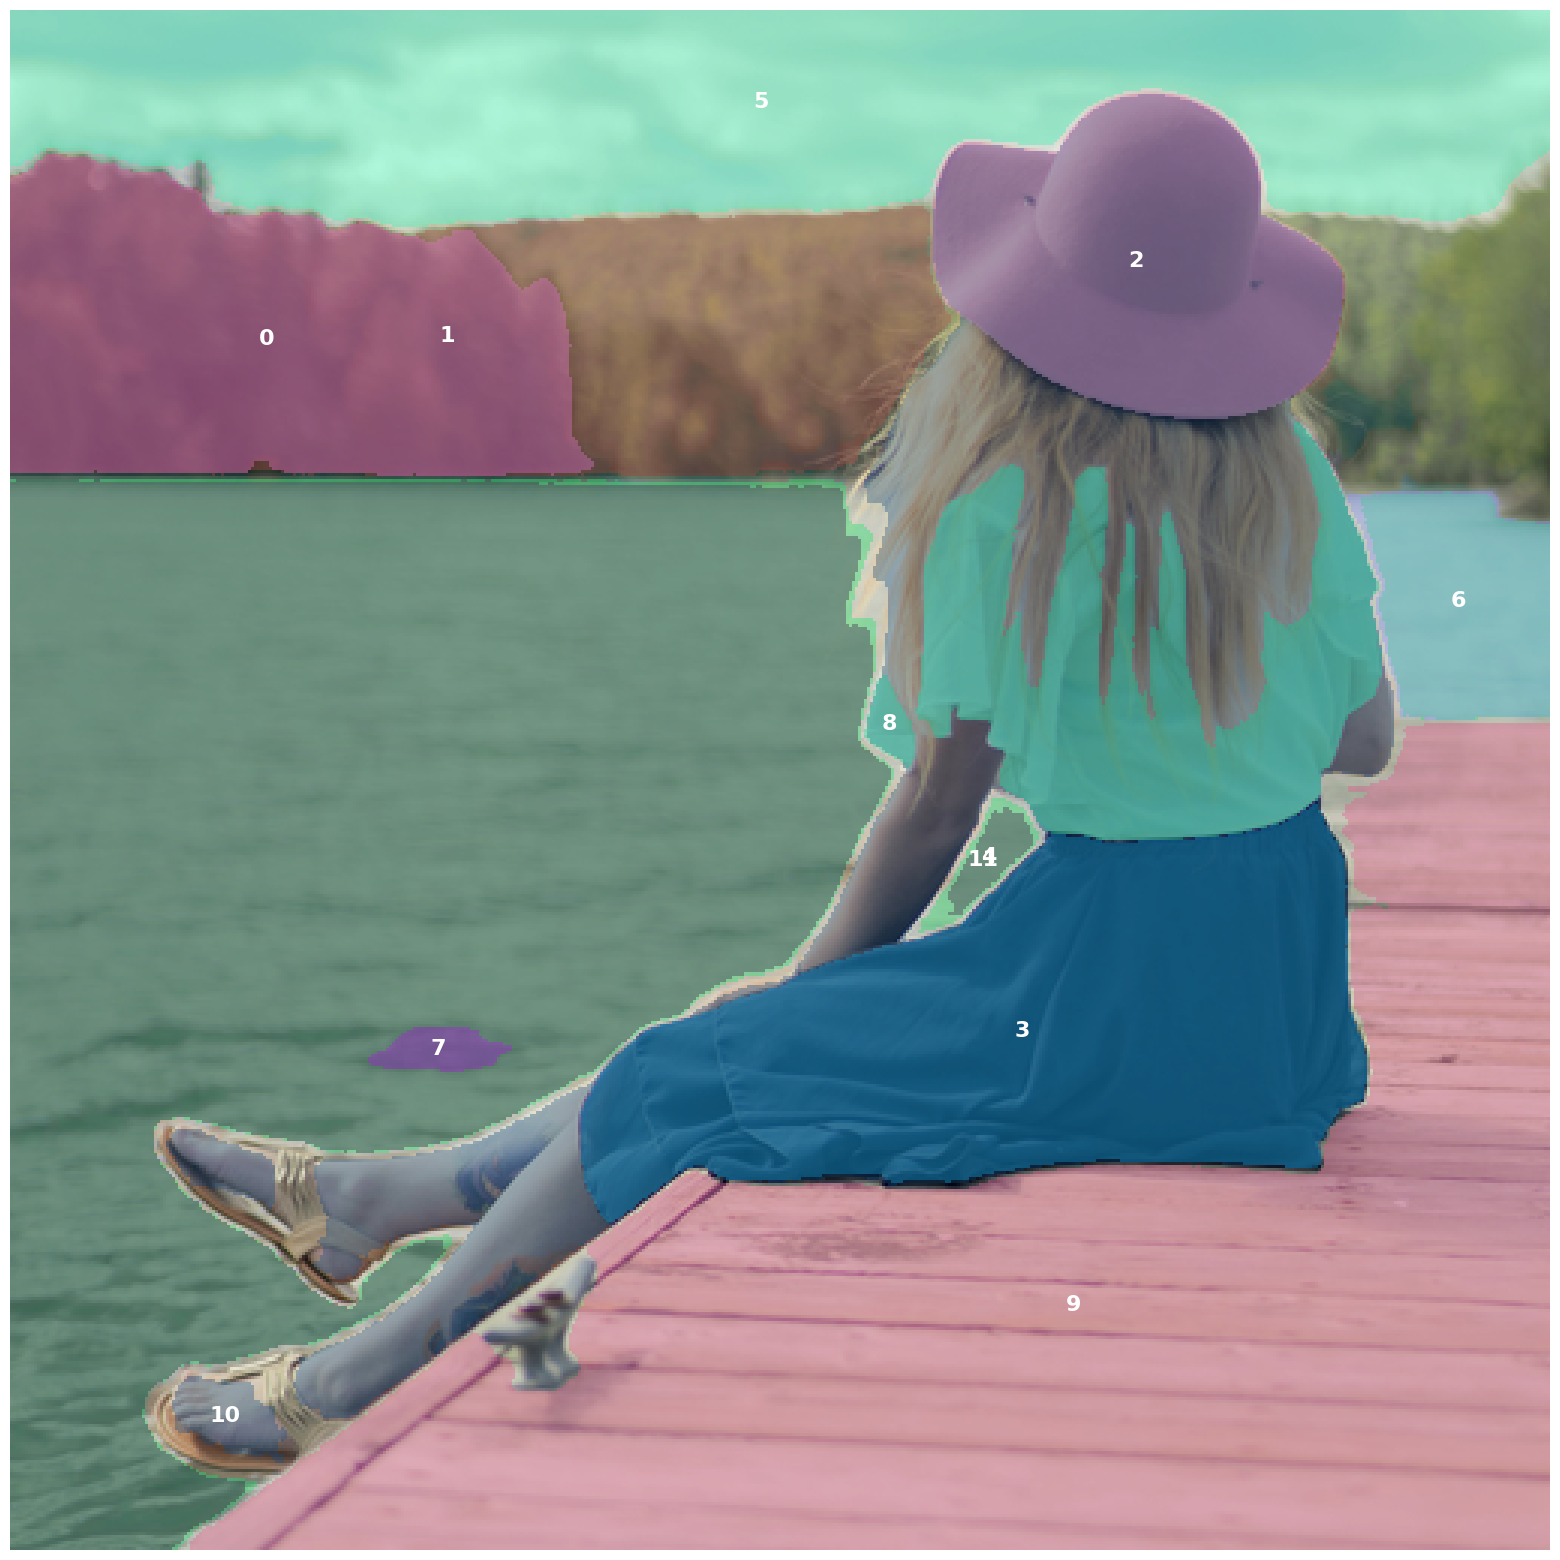

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(source_image)
show_anns(masks)
plt.axis('off')
plt.show()

## Explore Results

In [ ]:
for i, values in enumerate(masks):
   print(f"{i}: Area: {values['area']} | IoU: {values['predicted_iou']}")

# IoU: 0 means no overlap and 1 means perfect overlap

0: Area: 16164 | IoU: 1.0142308473587036
1: Area: 26577 | IoU: 0.9997087717056274
2: Area: 10621 | IoU: 1.019110918045044
3: Area: 21739 | IoU: 1.0302727222442627
4: Area: 66830 | IoU: 1.015101671218872
5: Area: 29775 | IoU: 1.012749195098877
6: Area: 4155 | IoU: 1.0036128759384155
7: Area: 502 | IoU: 0.9981482625007629
8: Area: 11164 | IoU: 0.9930633306503296
9: Area: 54736 | IoU: 1.042468547821045
10: Area: 63213 | IoU: 1.0088672637939453
11: Area: 71867 | IoU: 1.0054936408996582


# Editing the masks

## Select a mask

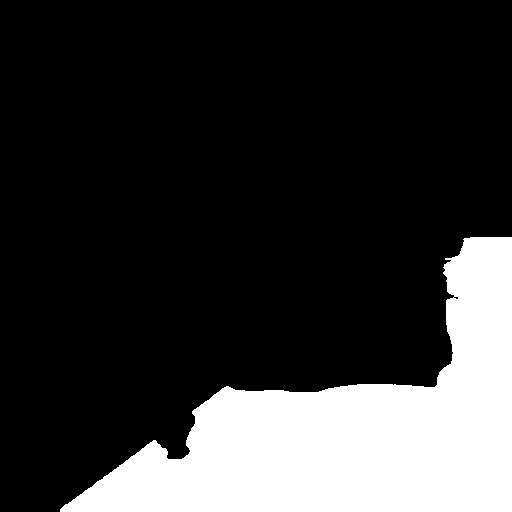

In [ ]:
# Define mask index #
mask_index = 9

# Get mask from model #
segmentation_mask = masks[mask_index]['segmentation']

# Convert from array to a PIL object #
stable_diffusion_mask=PIL.Image.fromarray(segmentation_mask)

# Display the created mask #
display(stable_diffusion_mask)

# Setup and Running Generation with Prompts

In [18]:
num_images_per_prompt = 4
inpainting_prompts = ['sand','boat','mountain','grassy area']

generator = torch.Generator(device="cuda").manual_seed(77)

# Run Stable Difussion pipeline in inpainting mode #
encoded_images = []
# Iterate over the prompts #
for i in range(num_images_per_prompt):
        image = pipe(
            prompt = inpainting_prompts[i],
            # How closely the result image is to the prompt = lower will deviate more from prompt (default = 7.5) #
            guidance_scale=7.5,
            # Denoising num of steps between noise to result image = more steps = high quality / slower (default = 50) #
            num_inference_steps=60,
            generator=generator,
            image=source_image,
            mask_image=stable_diffusion_mask
            ).images[0]

        encoded_images.append(image)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

# Visualization function using plt

In [19]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()

# See results

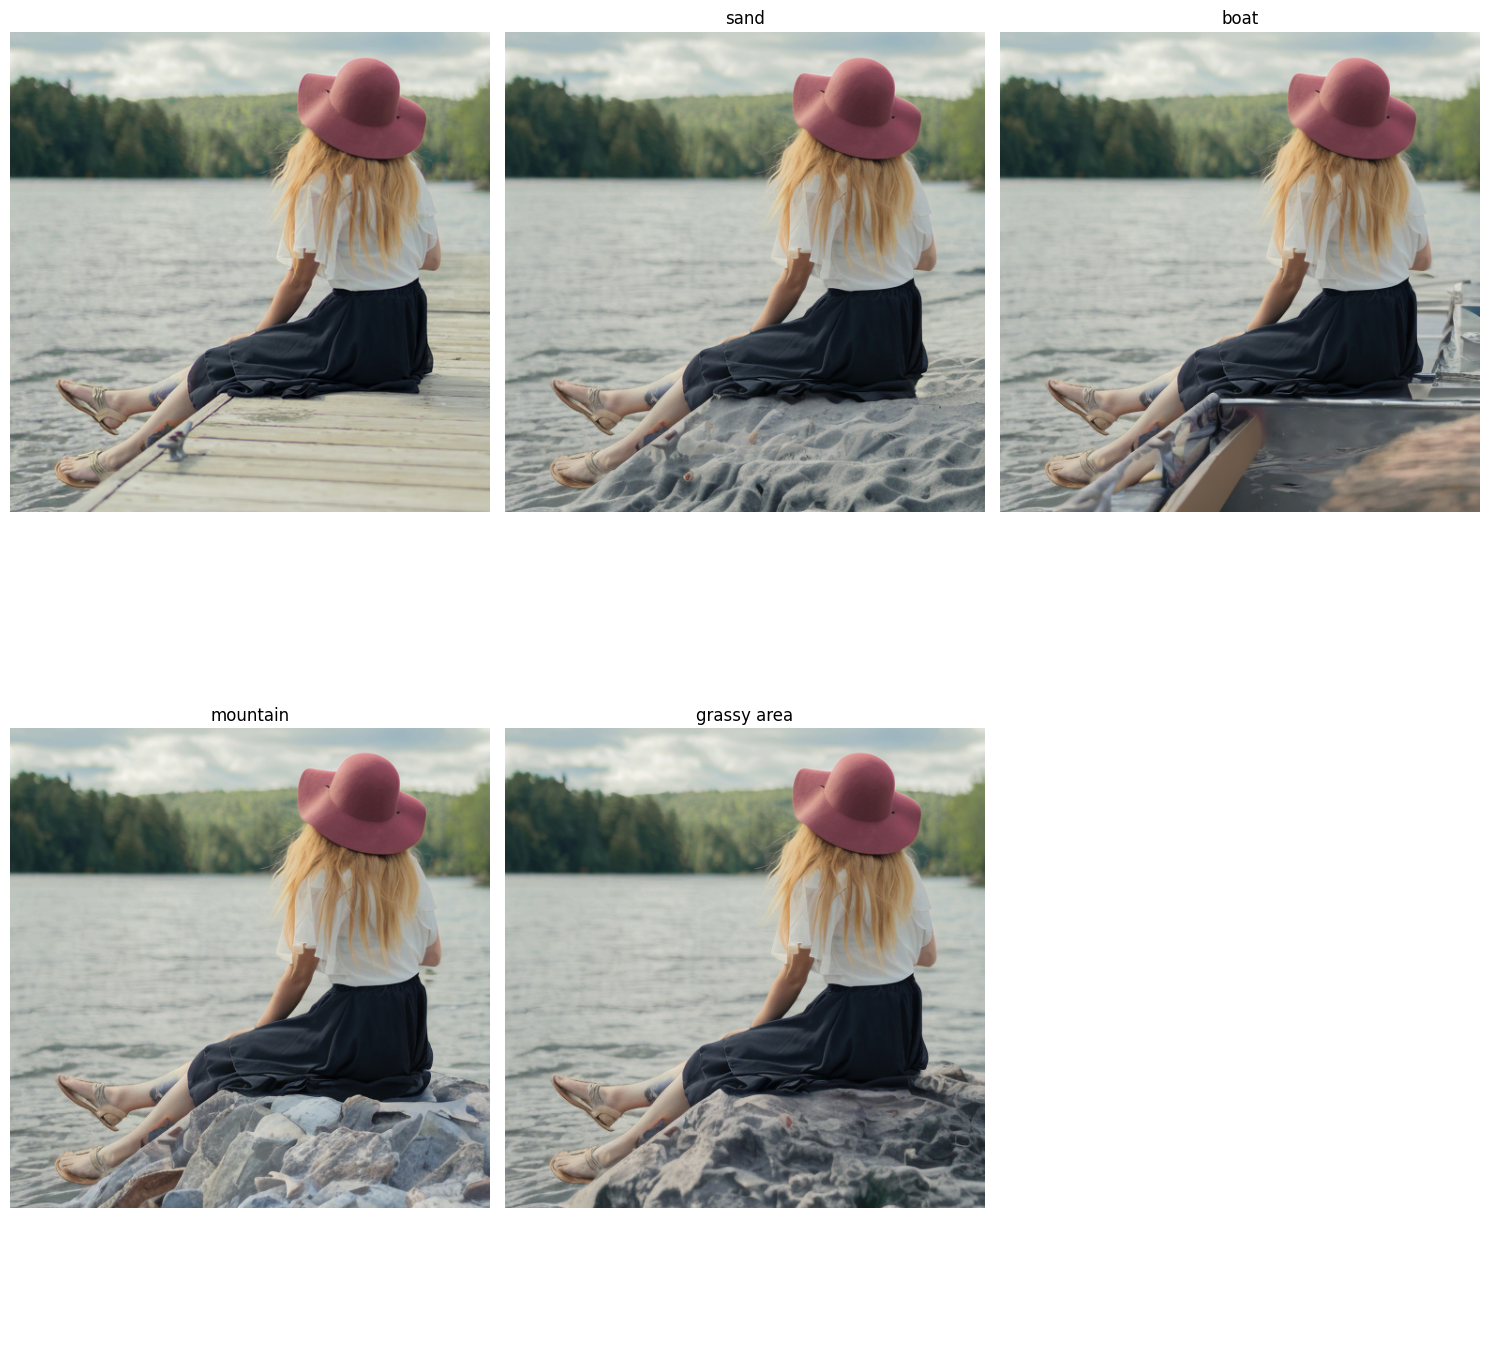

In [20]:
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)